figure = 66.66
bottle = 62.96
pen = 54.54

In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from metrics_utils import * 
from infer_utils import * 

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 3 #id of the object in the category

In [3]:
split_train = r"Objects_train/"
split_test = r"Objects_test/"

## Init the Valid Input Point Model 

In [4]:
args_infer = {
    "model_path" : "runs/bottle_2_single.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE
}

In [5]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128,input_cls=1)
dataset_train = JacquardSamples(dataset_root= split_train ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=4)
dataset = JacquardSamples(dataset_root= split_test ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=7)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

classes ['8b5a96b72767f7354fac5eaf08c4d9ce', 'acb1617efd51854339ad6b48a26028ff', '82a0ba979f437d0730d32956603b1f19', 'd67f1effed6e65fb2c45f75322191dd7', '7c6491c7fe65449cd9bdef3310c0e5a6', '611f9690f6eb4da79a6a8a8f3fa61f11', '6f67cd916a3cb630853d6ffb3e180267', '4ca3850427226dd18d4d8cbfa622f635']
classes ['1cbc0504316634ed80f698ab340a8570', '334bf3542211da33e858db1dc3499392', '2497bd27b94a197b698580924e57a755', 'abc933b264e3282442a65392abbe6885', '4c992058eca403d9980a39e0273687b1', 'edcbeac5da0b42dd7936acbca381136f', 'b1f4459eae651d4a1e4a40c5ca6a557d', 'e7b9fef210fa47505615f13c9cba61e5', 'e6809c021f1319b035836c728d324152', '351f967473e61599ca5852e989a25dd3', '812f1cbea6093044e3f7a74e12a274ef', 'ffc8c740dfb066de2e5e4d317752daae', 'bb66f1e88c53601726f0038a269bcb7c', '5f5271bf1d62599de3f7a74e12a274ef', 'd74bc917899133e080c257afea181fa2', '8bf17934792a107ee3f7a74e12a274ef', '866ba2af4ee624d0f44c04861b156235', 'b095a1c41447e9da887d2d6e4a6617b3', 'b0d444c3570b831be1e09e3c89252abb', '4e371e30a

## Init the Second Point Model 

In [6]:
args_infer_single = {
    "model_path" : "runs/bottle_1_double_sampling.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}


In [7]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model_single = BCEGraspTransformer(img_size=args_infer_single["img_size"],int_dim=256,output_dim=32,input_cls=3)
model_single.load_state_dict(torch.load(args_infer_single["model_path"]))
model_single = model_single.to(device)

In [8]:
constrain_mode = True
TOPK = True
topk_grasps = 1
topk_input = 50

In [9]:
max_dist =0
min_dist = 999999
for i in range(len(dataset_train)):
    data = dataset_train[i]
    img = data["img"].to(device)
    img = torch.permute(img, (0, 2, 1))
    mask = data["mask"].sum().sqrt()
    all_points = torch.tensor(data["points_grasp"]//14)
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min() and dif_n.min()>0:
        min_dist = dif_n.min()
if min_dist < 0.01:
    min_dist = 0.01

/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)
/tmp/ipykernel_305720/3396165159.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(data["points_grasp"]//14)


In [10]:
print(min_dist)

0.01


In [11]:
print(len(dataset))

7968


### Loop over the data and get the metrics

In [12]:
import time
from tabulate import tabulate

In [21]:
accuracies = []
print_every = 500
for test_idx in range(len(dataset)): 
    #test_idx = 13
    start = time.time()
    data = dataset[test_idx]
    img = data["img"].to(device)
    mask = data["mask"].to(device)
    img = torch.permute(img, (0, 2, 1))
    grasp = data["points_grasp"]//14
    normal_grasp = grasp.clone()
    grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
    grasp = torch.cat([grasp, grasp_inv], dim=0)
    #get features from dino
    features,_ = model.forward_dino_features(img.unsqueeze(0))
    features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

    #plt.figure(figsize=(16,16))
    org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
    end = time.time() - start
    #plt.imshow(org_image)


    ## get valid points
    all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)

    start_valid_pts = time.time()
    preds, preds_patches = get_valid_points(all_points, features, model, device,PATCH_DIM=PATCH_DIM)
    end_valid_pts = time.time() - start_valid_pts 
    
    start_topk = time.time()
    preds_cp, pts, valid_pts_pred = get_topk_valid_points(preds,preds_patches, mask, topk_num=topk_input,TOP_K=TOPK)
    end_topk = time.time() - start_topk
    
    #get second point informations 
    start_second_point = time.time()
    mask, mask_n, _, _, grasp, heights, corners = get_second_point_data(dataset,4,model_single,device,args_infer, inv_transform,test_idx=test_idx)
    end_second_point = time.time() - start_second_point
    num_grasps = valid_pts_pred.shape[0]
    #objs = 1


    data = {}
    data['mask'] = mask
    data['valid_pts_pred'] = valid_pts_pred
    data['min_dist'] = min_dist
    data['max_dist'] = max_dist
    data['heights'] = heights 
    data['args_infer'] = args_infer
    data['mask_n'] = mask_n
    data['device'] = device
    data['features'] = features
    data['model_single'] = model_single

    ##currently only support constraint mode == false
    
    start_pred = time.time()
    print('num_grasps', num_grasps)
    items = get_predictions(num_grasps,data,constrain_mode=constrain_mode)
    end_pred = time.time() - start_pred
    
    start_vis = time.time()
    cur_accuracy = vis_preds_with_metrics(num_grasps, items, org_image, grasp,heights, args_infer,preds_cp,topks=topk_grasps)
    end_vis = time.time() - start_vis
    
    accuracies.append(cur_accuracy)
    
    all_runtime = float(end + end_valid_pts + end_topk + end_second_point + end_pred + end_vis) 
    data = [['Dinov2',round(end / all_runtime,4) * 100, round(end,4) * 1000], 
            ['Valid Points', round(end_valid_pts/ all_runtime,2) * 100, round(end_valid_pts,4) * 1000],    
            ['Topk', round(end_topk/ all_runtime,4) * 100, round(end_topk,4) * 1000],
            ['Second Point', round(end_second_point/ all_runtime,4) * 100, round(end_second_point,4) * 1000],
            ['Prediction', round(end_pred/ all_runtime,4) * 100,round(end_pred,4) * 1000],
            ['Visualization',round( end_vis/ all_runtime,4) * 100,round(end_vis,4) * 1000],       
    ]
    
    headers = ['Module Type', 'Runtime Percentage', 'Time in ms']
    table = tabulate(data, headers=headers, tablefmt="grid")
    print(table)
        
    #except : 
    #    print('issue with eval')
    #    #accuracies.append(0)
     
    print("idx", test_idx)
    if test_idx % print_every == 0: 
        print("Iteration", test_idx)
        print('Object accuracy is', sum(accuracies)/len(accuracies))



/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)


num_grasps 50
+---------------+----------------------+--------------+
| Module Type   |   Runtime Percentage |   Time in ms |
+===============+======================+==============+
| Dinov2        |                10.87 |        241   |
+---------------+----------------------+--------------+
| Valid Points  |                29    |        649.5 |
+---------------+----------------------+--------------+
| Topk          |                 0.07 |          1.4 |
+---------------+----------------------+--------------+
| Second Point  |                17.95 |        397.8 |
+---------------+----------------------+--------------+
| Prediction    |                39.73 |        880.5 |
+---------------+----------------------+--------------+
| Visualization |                 2.07 |         45.9 |
+---------------+----------------------+--------------+
idx 0
Iteration 0
Object accuracy is 0.0
num_grasps 50
+---------------+----------------------+--------------+
| Module Type   |   Runtime Percent

KeyboardInterrupt: 

<Figure size 1600x1600 with 0 Axes>

In [ ]:
print(org_image.shape)

(1120, 1120, 3)


In [20]:
print(torch.unique(preds))

tensor([0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


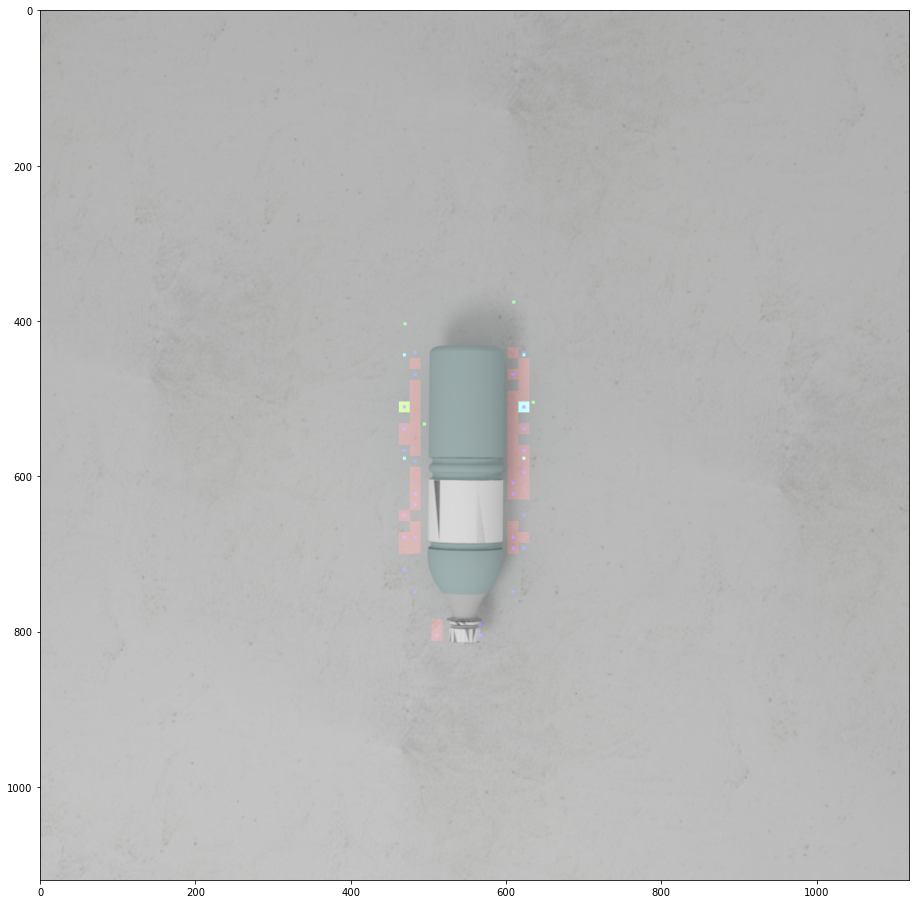

In [22]:
plt.figure(figsize=(16,16))
plt.imshow(org_image + origin_point*0.7)